## Front matter

In [40]:
from pathlib import Path # For navigating to the datafiles
import json # For processing json files
import csv # For processing csv files

from functools import reduce # So Chris can pretend he's a CS major

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # For simple graphing
import seaborn as sns # For sns.set_style("whitegrid"), I guess?

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Load json data into raw dataframes

In [49]:
# Read "well_formatted_json_files.txt"

data_files_to_read_path = Path('well_formatted_json_files.txt')
with open(data_files_to_read_path) as file:
    lines = file.read().splitlines()
    # Remove commented lines and blank lines:
    lines = [li for li in lines if ((li[0] != '#') and ( li.strip()))]
    print(len(lines))

10


In [58]:
# Read in json and tsv files

data_path = Path('data')

l = list()
for li in lines:
    # Read into dataframes
    
    json_path = data_path / Path(li + '_tweets.json')
    with open(json_path) as file:
        very_raw_json_contents = json.load(file)
    raw_json_contents = [x['user'] for x in very_raw_json_contents]
    json_contents = pd.DataFrame(raw_json_contents)
    tsv_path = data_path / Path(li + '.tsv')
    tsv_contents = pd.read_csv(tsv_path, sep='\t')
    tsv_contents.columns = ['user_id','species']
    
    # Set indexes to user ids and remove duplicate indices
        
    json_contents = json_contents.set_index('id')
    tsv_contents = tsv_contents.set_index('user_id')
    json_contents = json_contents.loc[~json_contents.index.duplicated(keep='last')]
    tsv_contents = tsv_contents.loc[~tsv_contents.index.duplicated(keep='last')]
    
    # Merge
    
    merged_data = pd.concat([json_contents, tsv_contents], join='inner', axis = 1)
    merged_data = merged_data.assign(source=li)
    
    l.append(merged_data)


cumulative_raw_data = reduce(lambda x, y : pd.concat([x,y]), l)

Be cautioned that some of the entries in the dataframe are json objects that got turned into python dictionaries. Python dictionaries are not hashable, so this can cause methods like `df.drop_duplicates` to fail. Perhaps remove these unhashable columns...

In [67]:
cumulative_raw_data

,follow_request_sent,has_extended_profile,profile_use_background_image,default_profile_image,profile_background_image_url_https,verified,translator_type,profile_text_color,profile_image_url_https,profile_sidebar_fill_color,...,url,created_at,contributors_enabled,time_zone,protected,default_profile,is_translator,species,source,withheld_in_countries
602249341,False,False,False,False,https://abs.twimg.com/images/themes/theme4/bg.gif,False,none,000000,https://pbs.twimg.com/profile_images/923924342...,000000,...,https://t.co/e5t6p9w7D8,Thu Jun 07 22:16:27 +0000 2012,False,London,False,False,False,human,botometer-feedback-2019,NaN
797617218511060992,False,True,False,False,https://abs.twimg.com/images/themes/theme1/bg.png,False,none,000000,https://pbs.twimg.com/profile_images/855244571...,000000,...,None,Sun Nov 13 01:48:58 +0000 2016,False,Pacific Time (US & Canada),False,False,False,bot,botometer-feedback-2019,NaN
889925474,False,False,True,False,https://pbs.twimg.com/profile_background_image...,False,none,333333,https://pbs.twimg.com/profile_images/964079832...,DDEEF6,...,http://t.co/7gh2Iu1AT4,Thu Oct 18 23:19:38 +0000 2012,False,None,False,False,False,human,botometer-feedback-2019,NaN
96435556,False,True,True,False,https://abs.twimg.com/images/themes/theme6/bg.gif,False,none,333333,https://pbs.twimg.com/profile_images/311429969...,A0C5C7,...,None,Sat Dec 12 22:53:04 +0000 2009,False,Rome,False,False,False,bot,botometer-feedback-2019,NaN
16905397,False,False,True,False,https://pbs.twimg.com/profile_background_image...,False,regular,666666,https://pbs.twimg.com/profile_images/969705141...,252429,...,https://t.co/VRgsX8eVR2,Wed Oct 22 13:43:42 +0000 2008,False,Bern,False,False,False,human,botometer-feedback-2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76235237,False,True,False,False,https://abs.twimg.com/images/themes/theme14/bg...,True,none,000000,https://pbs.twimg.com/profile_images/969605999...,000000,...,https://t.co/XWFZ4aqcZ4,Tue Sep 22 03:10:00 +0000 2009,False,None,False,False,False,human,verified-2019,NaN
2159329092,False,False,False,False,https://abs.twimg.com/images/themes/theme1/bg.png,True,none,000000,https://pbs.twimg.com/profile_images/112290924...,000000,...,https://t.co/OJ69l0pxyk,Sun Oct 27 17:46:59 +0000 2013,False,None,False,False,False,human,verified-2019,NaN
25527618,False,True,True,False,https://abs.twimg.com/images/themes/theme10/bg...,True,none,3D1957,https://pbs.twimg.com/profile_images/110004956...,7AC3EE,...,https://t.co/IiGhu084D5,Fri Mar 20 16:12:36 +0000 2009,False,None,False,False,False,human,verified-2019,NaN
43654274,False,False,True,False,https://abs.twimg.com/images/themes/theme14/bg...,True,none,333333,https://pbs.twimg.com/profile_images/297271636...,EFEFEF,...,https://t.co/wBpiJ5kRRf,Sun May 31 06:37:34 +0000 2009,False,None,False,False,False,human,verified-2019,NaN


These should be the column names of raw_data:

* profile_sidebar_border_color
* name
* profile_background_image_url
* listed_count
* favourites_count
* created_at
* followers_count
* friends_count
* profile_background_color
* id_str
* is_translation_enabled
* translator_type
* profile_use_background_image
* notifications
* is_translator
* profile_sidebar_fill_color
* utc_offset
* follow_request_sent
* default_profile
* id
* verified
* default_profile_image
* profile_text_color
* entities
* profile_background_tile
* protected
* profile_background_image_url_https
* location
* profile_image_url
* following
* lang
* geo_enabled
* time_zone
* profile_image_url_https
* profile_link_color
* url
* statuses_count
* screen_name
* has_extended_profile
* description
* contributors_enabled

Here is a dictionary for all this: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object. The Twitter API dictionary says not all of these attributes are still used; some are deprecated and null in every entry. However, as the next section shows, most of the attributes in the datasets are usable after all. (They must have been deprecated from the API sometime after this data was collected.)

## Which attributes are mostly null?

In [60]:
def how_na_are_cols(df_arg):
    print(f'total number of observations is {len(df_arg)}')
    print()
    for col_name in df_arg.columns:
        print('NA values in column {:35} : {}'.format(
              col_name, df_arg[col_name].count()))

In [61]:
how_na_are_cols(cumulative_raw_data)

total number of observations is 44595

NA values in column follow_request_sent                 : 44595
NA values in column has_extended_profile                : 44595
NA values in column profile_use_background_image        : 44595
NA values in column default_profile_image               : 44595
NA values in column profile_background_image_url_https  : 39647
NA values in column verified                            : 44595
NA values in column translator_type                     : 44595
NA values in column profile_text_color                  : 44595
NA values in column profile_image_url_https             : 44595
NA values in column profile_sidebar_fill_color          : 44595
NA values in column entities                            : 44595
NA values in column followers_count                     : 44595
NA values in column profile_sidebar_border_color        : 44595
NA values in column id_str                              : 44595
NA values in column profile_background_color            : 44595
N

In [62]:
# Inspect how many null values are in each column

threshold = 40000

na_cols = [x for x in cumulative_raw_data.columns
               if (cumulative_raw_data[x].count()
               <= threshold)]

trimmed_raw_data = cumulative_raw_data.drop(na_cols, axis = 1)

print('dropped these columns with more than {} non-NA values:'.format(threshold))
print()
for x in na_cols: print(x)
print()
print()
print('These columns remain:')
print()
for x in trimmed_raw_data.columns: print(x)

dropped these columns with more than 40000 non-NA values:

profile_background_image_url_https
utc_offset
profile_banner_url
profile_background_image_url
url
time_zone
withheld_in_countries


These columns remain:

follow_request_sent
has_extended_profile
profile_use_background_image
default_profile_image
verified
translator_type
profile_text_color
profile_image_url_https
profile_sidebar_fill_color
entities
followers_count
profile_sidebar_border_color
id_str
profile_background_color
listed_count
is_translation_enabled
statuses_count
description
friends_count
location
profile_link_color
profile_image_url
following
geo_enabled
screen_name
lang
profile_background_tile
favourites_count
name
notifications
created_at
contributors_enabled
protected
default_profile
is_translator
species
source


In [68]:
cumulative_raw_data = pd.read_csv("Cumumative_Raw_Data.csv")


#Creating test train split for knn
X = cumulative_raw_data[['followers_count', 'friends_count', 'listed_count', 'favourites_count', ]].to_numpy()
y = cumulative_raw_data[['species']].to_numpy()

 
# make the test data 25% of the total data
# Set a random seed
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=440)

# import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

# Make the model
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the model
knn.fit(X_train,y_train.ravel())

# Make a prediction on our train set
y_predict = knn.predict(X_train)

# calculate the accuracy here
# sum a list of booleans and True gets cast as 1
# False gets cast as 0
print("Our model has a ",
      np.round(sum(y_predict == y_train.ravel())/len(y_train)*100,2),
      "% accuracy on the training set")


C:\Users\12018\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Our model has a  91.76 % accuracy on the training set


In [72]:
y_predict = knn.predict(X_test)
knn.fit(X_train, y_train.ravel())

print("Our model has a ",
      np.round(sum(y_predict == y_test.ravel())/len(y_test)*100,2),
      "% accuracy on the training set")

Our model has a  86.53 % accuracy on the training set


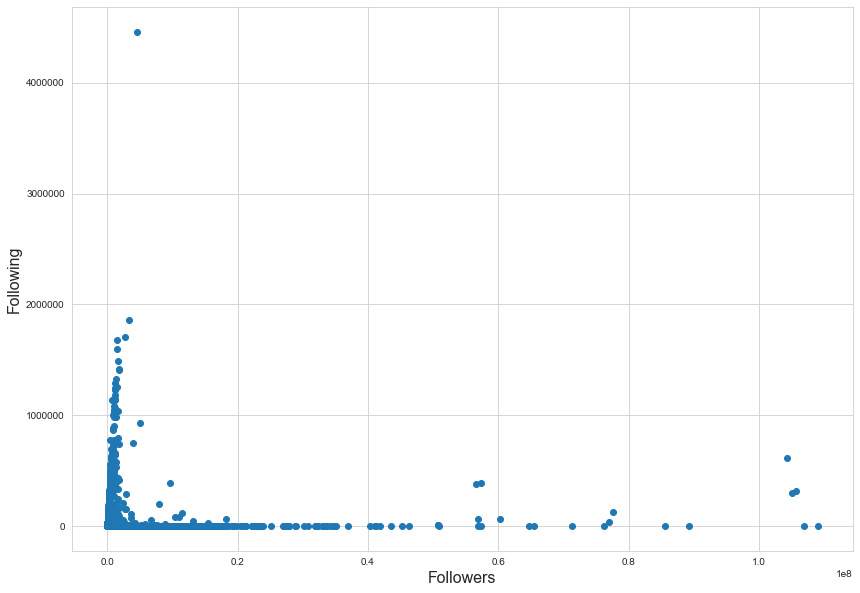

In [93]:
Bot_or_Not = pd.read_csv("Cumumative_Raw_Data.csv")
Bot_or_Not_copy = Bot_or_Not.copy()


Bot_or_Not_train = Bot_or_Not_copy.sample(frac=.75, random_state = 4444)
Bot_or_Not_test = Bot_or_Not_copy.drop(Bot_or_Not_copy.index)
plt.figure(figsize = (14,10))

plt.scatter(Bot_or_Not_train.followers_count, Bot_or_Not_train.friends_count)

plt.xlabel("Followers", fontsize=16)
plt.ylabel("Following", fontsize=16)


plt.show()






In [95]:
followers_count_mean = Bot_or_Not_train.followers_count.mean()
friends_count_mean = Bot_or_Not_train.friends_count.mean()

from sklearn.linear_model import LinearRegression
# Get the covariance and variance
cov = Bot_or_Not_train[['followers_count','friends_count']].cov().iloc[0,1]
followers_count_var = Bot_or_Not_train.followers_count.var()

# Calculate beta_1_hat
beta_1_hat = cov/followers_count_var

# Calculate beta_0_hat
beta_0_hat = friends_count_mean - beta_1_hat * followers_count_mean

print("By Hand")
print("beta_0_hat",np.round(beta_0_hat,3))
print("beta_1_hat",np.round(beta_1_hat,3))
print()

### sklearn
reg = LinearRegression(copy_X = True)

reg.fit(Bot_or_Not_train.followers_count.values.reshape(-1,1),
           Bot_or_Not_train.friends_count.values.ravel())

print("sklearn")
print("beta_0_hat",np.round(reg.intercept_,3))
print("beta_1_hat",np.round(reg.coef_[0],3))

By Hand
beta_0_hat 4182.313
beta_1_hat 0.001

sklearn
beta_0_hat 4182.313
beta_1_hat 0.001


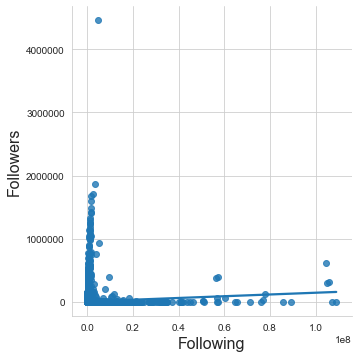

In [96]:
sns.lmplot(data = Bot_or_Not_train, x = 'followers_count', y = 'friends_count', ci = None)

plt.xlabel("Following", fontsize=16)
plt.ylabel("Followers", fontsize=16)

plt.show()

In [97]:
print("A 1 person increase in followers gives an estimated",
         np.round(beta_1_hat,4),
          "additional person following.")

A 1 person increase in followers gives an estimated 0.0014 additional person following.


In [100]:
def mse(y,y_pred,r):
    return np.round(np.sum((y-y_pred)**2)/len(y),r)

y_train = Bot_or_Not_train.friends_count.values.ravel()
y_train_pred = reg.predict(Bot_or_Not_train.followers_count.values.reshape(-1,1))

print("The training MSE is",mse(y_train,y_train_pred,4))



y_test = Bot_or_Not_train.friends_count.values.ravel()
y_test_pred = reg.predict(Bot_or_Not_train.followers_count.values.reshape(-1,1))

print("The testing MSE is",mse(y_test,y_test_pred,4))

The training MSE is 2890817541.9829
The testing MSE is 2890817541.9829


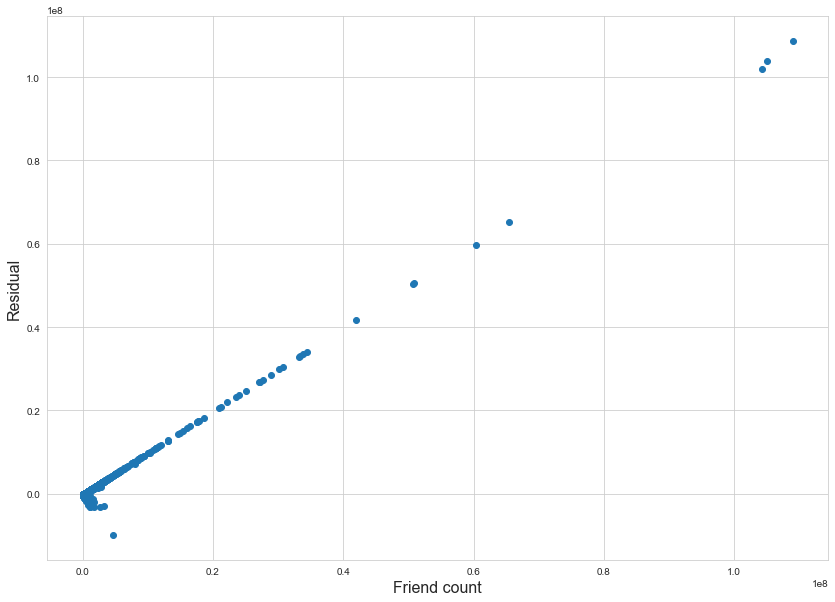

In [127]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# make the model object
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(Bot_or_Not_train.friends_count.values.reshape(-1,1),Bot_or_Not_train.followers_count.values.ravel())

# predict
pred = reg.predict(Bot_or_Not_train.friends_count.values.reshape(-1,1))

# Now get the residuals
res = Bot_or_Not_train.followers_count.values.ravel() - pred

plt.figure(figsize = (14,10))

plt.scatter(Bot_or_Not_train.followers_count,res)

plt.xlabel("Friend count", fontsize = 16)
plt.ylabel("Residual", fontsize = 16)

plt.show()

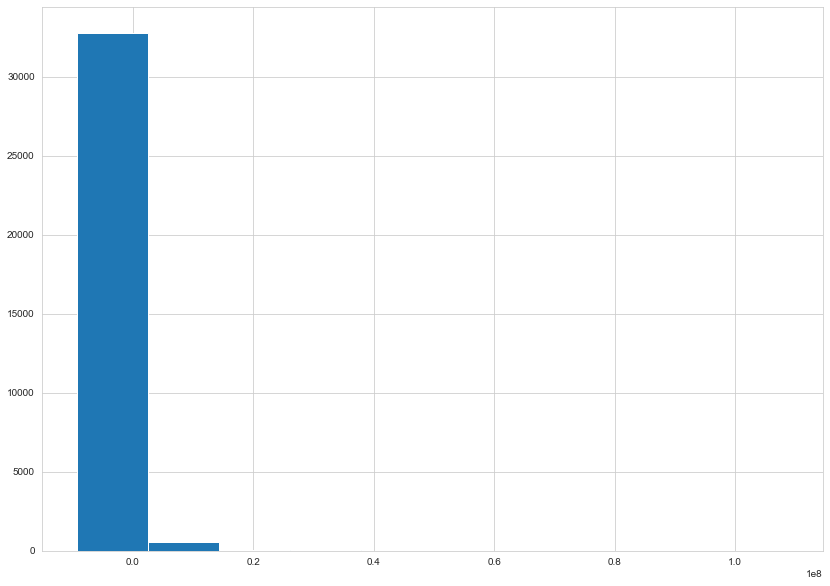

,followers_count,friends_count
followers_count,1.000000,0.064791
friends_count,0.064791,1.000000


In [106]:


plt.figure(figsize = (14,10))

plt.hist(res)

plt.show()



Bot_or_Not_train[['followers_count','friends_count']].corr()

In [123]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
Cumumative_Raw_Data.csv = Cumumative_Raw_Data.csv[:10000]
bot_labels = pd.read_csv('Cumumative_Raw_Data.csv', names = ['id', 'identity'], sep = '\t')
human_labels = pd.read_csv('Cumumative_Raw_Data.csv', names = ['id', 'identity'], sep = '\t')

botlabels['bot'] = 1
humanlabels['bot'] = 0
# First set all beers as 0
Cumumative_Raw_Data_train['bot'] = 0
# Then locate all the stouts and set Stout to 1
Cumumative_Raw_Data_train.loc[Cumumative_Raw_Data_train.Cumumative_Raw_Data_Type == "bot",'bot'] = 1



NameError: name 'Cumumative_Raw_Data' is not defined

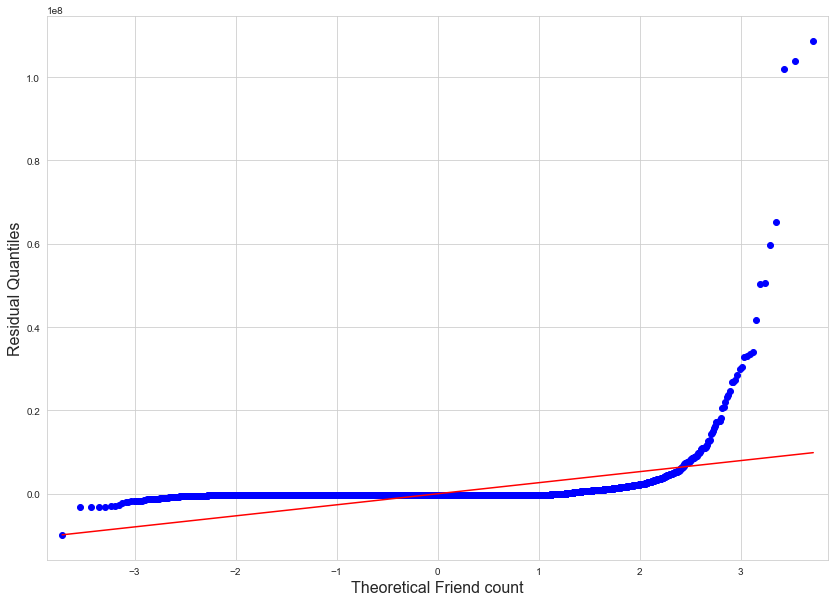

In [129]:
import statsmodels.api as sm 

fig,ax = plt.subplots(figsize=(14,10))

# qqplot makes the qqplot
# put in the data you want to plot
# line = 's' plots a line fit to our data
# ax=ax allows us to put the data on the plt subplot object I made
sm.qqplot(res,line='s',ax=ax) 

# Normals go on the x-axis
plt.xlabel("Theoretical Friend count", fontsize=16)

# Residuals on the y-axis
plt.ylabel("Residual Quantiles", fontsize=16)


plt.show() 

In [131]:

reg.fit(Bot_or_Not_train.friends_count.values.reshape(-1,1),Bot_or_Not_train.followers_count.values.ravel())


# Cast the data as np.arrays
# reshape(-1,1) makes it a column vector
y = np.array(Bot_or_Not_train.followers_count.values.reshape(-1,1))
fc = np.array(Bot_or_Not_train.friends_count.values.reshape(-1,1))

# We need to add a column of ones in order to allow for
# a constant
X = np.concatenate([np.ones(np.shape(fc)),fc],axis=1)


# Fit a simple linear regression model
# sm.OLS stands for Ordinary Least Squares, this
# is the name for the method used to get the coefficients
# First put y, then X
slr = sm.OLS(y, X)

# Now fit the model
fit = slr.fit()

# fit.summary makes a snazy table for us to look at
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     66.85
Date:                Sun, 31 May 2020   Prob (F-statistic):           3.28e-16
Time:                        04:28:43   Log-Likelihood:            -1.6210e+05
No. Observations:               10000   AIC:                         3.242e+05
Df Residuals:                    9998   BIC:                         3.242e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.123e+05   2.66e+04     11.741      0.0

In [139]:
## Code here
speci = pd.read_csv("Cumumative_Raw_Data.csv")

print("There are", len(species), "observations in the data set.")
print("The columns are", species.columns)

# Check the percentage of each species_Type to
# see if we need to stratify our train test split
speci.species.value_counts(normalize=True)




There are 44595 observations in the data set.
The columns are Index(['Unnamed: 0', 'follow_request_sent', 'has_extended_profile',
       'profile_use_background_image', 'default_profile_image',
       'profile_background_image_url_https', 'verified', 'translator_type',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_fill_color', 'entities', 'followers_count',
       'profile_sidebar_border_color', 'id_str', 'profile_background_color',
       'listed_count', 'is_translation_enabled', 'utc_offset',
       'statuses_count', 'description', 'friends_count', 'location',
       'profile_link_color', 'profile_image_url', 'following', 'geo_enabled',
       'profile_banner_url', 'profile_background_image_url', 'screen_name',
       'lang', 'profile_background_tile', 'favourites_count', 'name',
       'notifications', 'url', 'created_at', 'contributors_enabled',
       'time_zone', 'protected', 'default_profile', 'is_translator', 'species',
       'source', 'withhe

bot      0.636596
human    0.363404
Name: species, dtype: float64

In [144]:
# train test split
speci_copy = speci.copy()

speci_train = speci_copy.sample(frac=.75,random_state = 4444)
speci_test = speci_copy.drop(speci_train.index)

# Sanity check to see our percentages are close 
# to the same as the original
speci_train.species.value_counts(normalize=True)





bot      0.636967
human    0.363033
Name: species, dtype: float64

In [158]:
# import the packages we'll use


## For data handling
import pandas as pd
import numpy as np

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")


# We can do it by hand
# First set all beers as 0
speci_train['bot'] = 0

# Then locate all the stouts and set Stout to 1
speci_train.loc[speci_train.species == "bot",'bot'] = 1

# We'll use sklearn
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(speci_train[['friends_count','bot']],speci_train['followers_count'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

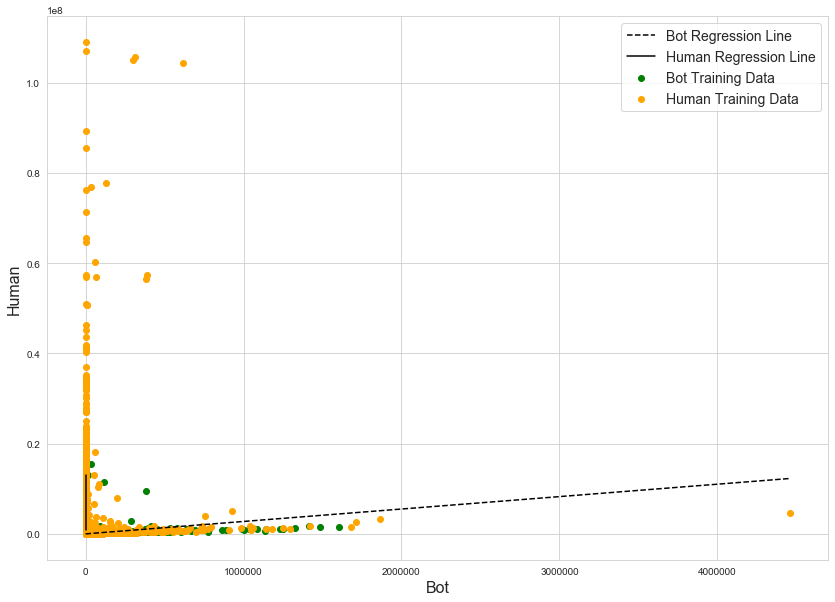

In [184]:
# We can plot the two lines by limiting our prediction input
bot_values = np.ones((100,2))
bot_values[:,0] = np.linspace(speci_train['friends_count'].min(),speci_train['friends_count'].max(),100)

# make a stout prediction
bot_pred = reg.predict(bot_values)

# make ipa values
human_values = np.zeros((100,2))
human_values[:,0] = np.linspace(speci_train['friends_count'].min(),speci_train['friends_count'].max(),100)
human_pred = reg.predict(human_values)


# Let's plot
plt.figure(figsize=(14,10))

# plot stout values
plt.scatter(speci_train.loc[speci_train.bot == 1,'friends_count'], 
               speci_train.loc[speci_train.bot == 1,'followers_count'],
               c = 'green', alpha = 1, label="Bot Training Data")

# plot the stout line
plt.plot(bot_values[:,0], bot_pred, "k--", label="Bot Regression Line")

# plot ipa values
plt.scatter(speci_train.loc[speci_train.bot == 0,'friends_count'], 
               speci_train.loc[speci_train.bot == 0,'followers_count'],
               c = 'orange', alpha = 1, label="Human Training Data")

# plot the ipa line
plt.plot(human_values[:,1], human_pred, "k", label="Human Regression Line")

plt.legend(fontsize = 14)

plt.xlabel("Bot",fontsize=16)
plt.ylabel("Human",fontsize=16)

plt.show()

In [195]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

speci = pd.read_csv("CRL_Raw_Data.csv")

# train test split
speci_copy = speci.copy()

# Then locate all the stouts and set Stout to 1
speci_copy['bot'] = 0
speci_copy.loc[speci_copy.species == "Bot",'Bot'] = 1

speci_train = speci_copy.sample(frac=.75,random_state = 100)
speci_test = speci_copy.drop(speci_train.index)

speci_train.head()


C:\Users\12018\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,followers_count,Unnamed: 2,friends_count,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 37,Unnamed: 38,Unnamed: 39,default_profile,Unnamed: 41,species,source,withheld_in_countries,bot,Bot
39387,3.371991e+09,36,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,bot,pronbots-2019,NaN,0,NaN
44459,1.095795e+08,30869,NaN,2033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,human,verified-2019,NaN,0,NaN
21228,2.260405e+08,92534,NaN,7707,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,human,gilani-2017,NaN,0,NaN
5845,2.534150e+08,1691175,NaN,78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,human,celebrity-2019,NaN,0,NaN
43912,3.250521e+09,5572,NaN,423,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,human,verified-2019,NaN,0,NaN


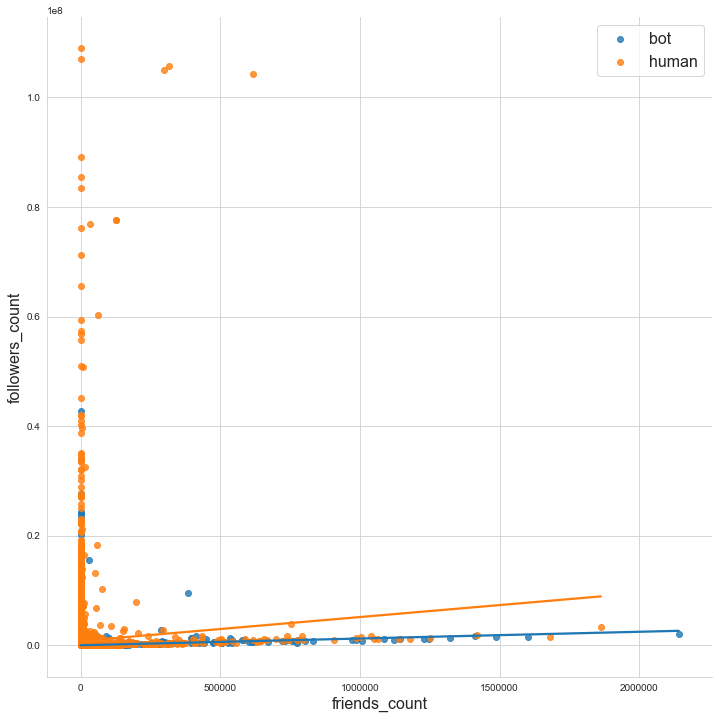

In [201]:
# We can do it by hand
# First set all beers as 0
speci_train['bot'] = 0

# Then locate all the stouts and set Stout to 1
speci_train.loc[speci_train.species == "bot",'bot'] = 1

# We'll use sklearn
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(speci_train[['friends_count','bot']],speci_train['followers_count'])



# now plot a regression with "hue" listed as Beer_Type
sns.lmplot(data = speci_train, x="friends_count", y="followers_count", 
           hue = "species", height=10,  
           ci = False, legend=False)


bot_values = np.ones((100,2))
bot_values[:,0] = np.linspace(speci_train['friends_count'].min(),speci_train['friends_count'].max(),100)

human_values = np.zeros((100,2))
human_values[:,0] = np.linspace(speci_train['friends_count'].min(),speci_train['friends_count'].max(),100)
human_pred = reg.predict(human_values)

plt.xlabel("friends_count", fontsize=16)
plt.ylabel("followers_count", fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [202]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# x1 and x2 are our features
x1 = np.random.random(200)

# but x2 is actually a function of x1
x2 = 1-x1+.2*np.random.randn(200)

# y is the target
y = x1 + .2*np.random.randn(200)

# Hold this in a df
speci = pd.DataFrame({'x1':x1,'x2':x2,'y':y})

speci_copy = speci.copy()
speci_train = speci_copy.sample(frac = .75, random_state = 40)
speci_test = speci_copy.drop(speci_train.index)
speci_train.corr()

,x1,x2,y
x1,1.000000,-0.796935,0.812062
x2,-0.796935,1.000000,-0.640661
y,0.812062,-0.640661,1.000000


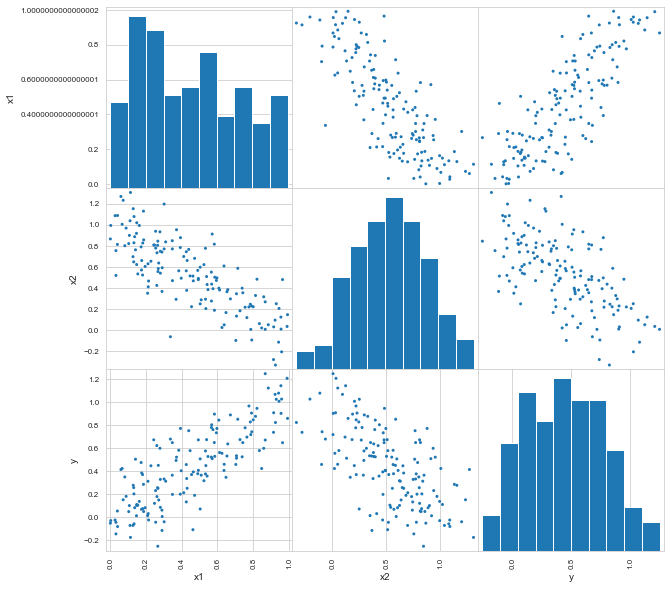

In [204]:
from pandas.plotting import scatter_matrix
scatter_matrix(speci_train, figsize=(10,10), alpha = 1)

plt.show()

In [205]:
# Import the package
import statsmodels.api as sm 
# We have to add in the constant for sm.OLS
speci_train['const'] = 1

# Fit a model with both x1 and x2
lr = sm.OLS(speci_train['y'], speci_train[['const','x1','x2']])

# Now fit the model
fit = lr.fit()

# fit.summary makes a snazy table for us to look at
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     142.4
Date:                Sun, 31 May 2020   Prob (F-statistic):           4.03e-35
Time:                        07:10:47   Log-Likelihood:                 31.190
No. Observations:                 150   AIC:                            -56.38
Df Residuals:                     147   BIC:                            -47.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0264      0.083     -0.319      0.7

In [206]:
# Now one with only x2
lr = sm.OLS(speci_train['y'], speci_train[['const','x2']])

# Now fit the model
fit = lr.fit()

# fit.summary makes a snazy table for us to look at
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     103.0
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.06e-18
Time:                        07:11:21   Log-Likelihood:                -9.9948
No. Observations:                 150   AIC:                             23.99
Df Residuals:                     148   BIC:                             30.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7720      0.039     19.610      0.0

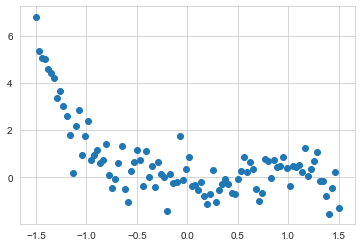

In [207]:
# Make 2 1-D arrays, x_train and x_test, both spaced from -1.5 to 1.5 with 100 
# evenly spaced entries
# np.linspace is helpful here
speci_train = np.linspace(-1.5,1.5,100)
speci_test = np.linspace(-1.5,1.5,100)
y_train = .1 + .2*speci_train**2 + .5*speci_train**4 - .5*speci_train**5 + .7*np.random.randn(100)
y_test = .1 + .2*speci_test**2 + .5*speci_test**4 - .5*speci_test**5 + .6*np.random.randn(100)
plt.scatter(speci_train,y_train)

plt.show()

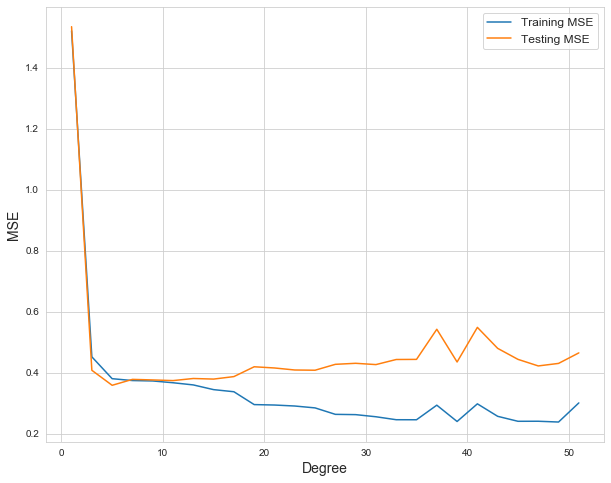

In [212]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# Make a loop from i = 1 to 31, skipping the even numbers,

# for each i make a pipeline that transforms x
# into a polynomial array of degree i
# then fit a regression of y on the powers of x
# record both the training set mse and the test set mse

def get_mse(model,X,y):
    pred = model.predict(X)
    res = y - pred
    return np.round(np.sum(np.power(res,2))/len(res),5)
    
train_mses = [] 
test_mses = []

for i in range(1,52,2):
    pipe = Pipeline([('poly',PolynomialFeatures(i,include_bias = False)),
                        ('reg',LinearRegression(copy_X = True))])
    
    pipe.fit(speci_train.reshape(-1,1),y_train)
    
    train_mses.append(get_mse(pipe,speci_train.reshape(-1,1),y_train))
    test_mses.append(get_mse(pipe,speci_test.reshape(-1,1),y_test))
    # Plot the degree vs the corresponding training and test mses
# Label them so you know which is which.
plt.figure(figsize=(10,8))


plt.plot(range(1,52,2), train_mses, label = "Training MSE")
plt.plot(range(1,52,2), test_mses, label = "Testing MSE")

plt.legend(fontsize=12)

plt.xlabel("Degree", fontsize=14)
plt.ylabel("MSE", fontsize=14)

plt.show()

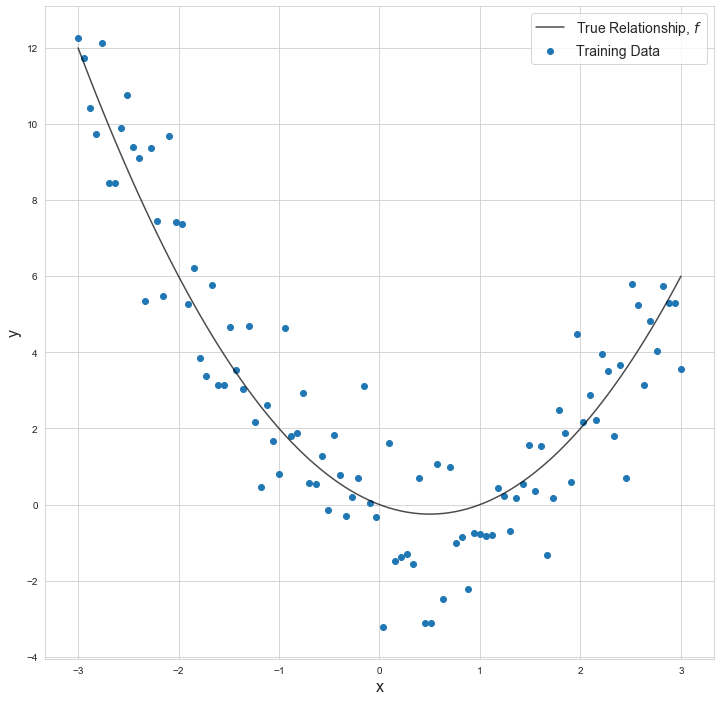

In [213]:
x = np.linspace(-3,3,100)
y = x*(x-1) + 1.2*np.random.randn(100)
plt.figure(figsize = (12,12))

plt.plot(x, x*(x-1),'k', label = "True Relationship, $f$", alpha = .7)
plt.scatter(x, y, label = "Training Data")

plt.ylabel("y", fontsize=16)
plt.xlabel("x", fontsize=16)

plt.legend(fontsize=14)

plt.show()

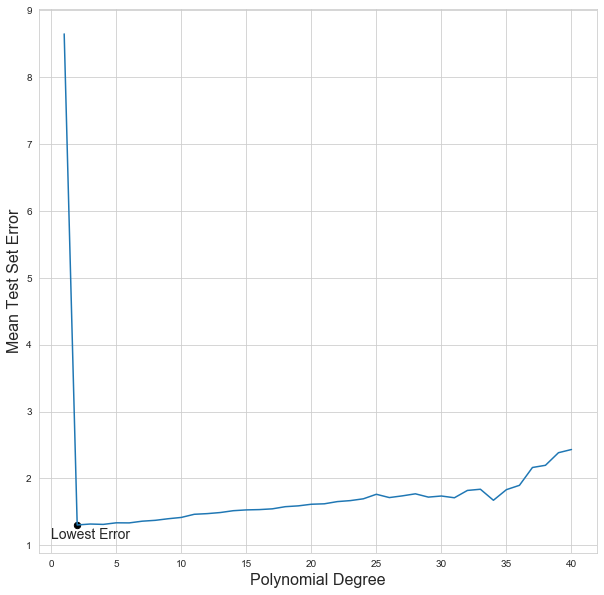

In [218]:
# Generate a single test set
speci_test = np.linspace(-3,3,100)
y_test = speci_test*(speci_test-1) + 1.2*np.random.randn(100)
test_errors = np.zeros((10,len(range(1,41))))

# We'll generate 10 training sets
for i in range(10):
    sepci = np.linspace(-3,3,100)
    y = x*(x-1) + 1.2*np.random.randn(100)

    
    for j in range(1,41):
        pipe = Pipeline([('poly',PolynomialFeatures(j)),
                             ('reg', LinearRegression(copy_X = True))])
        pipe.fit(x.reshape(-1,1),y)
        
        pred = pipe.predict(speci_test.reshape(-1,1))
        test_errors[i,j-1] = np.sum((pred - y_test)**2)/len(y_test)
        
plt.figure(figsize = (10,10))

plt.plot(range(1,41), np.mean(test_errors,axis=0))

plt.xlabel("Polynomial Degree", fontsize = 16)
plt.ylabel("Mean Test Set Error", fontsize = 16)

plt.scatter(np.argmin(np.mean(test_errors,axis=0)) + 1, 
         np.min(np.mean(test_errors,axis=0)), s=40, c="black")

plt.text(np.argmin(np.mean(test_errors,axis=0)) - 1, 
         np.min(np.mean(test_errors,axis=0)-.2), 
         "Lowest Error", fontsize = 14)

plt.show()        

In [219]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
n = 26
coef_holder = np.zeros((n,n))
# Now we'll fit the data with polynomials degree 1 through n
for i in range(1,n+1):
    # Make a pipe
    pipe = Pipeline([('poly',PolynomialFeatures(i,include_bias = False)),
                    ('reg',LinearRegression())])
    
    # fit the data
    pipe.fit(x.reshape(-1,1),y)
    
    # store the coefficient estimates
    coef_holder[i-1,:i] = np.round(pipe['reg'].coef_,3)
    # Display the coefficient estimates as a dataframe
pd.DataFrame(coef_holder, 
             columns = ["x^" + str(i) for i in range(1,n+1)],
            index = [str(i) + "_deg_poly" for i in range(1,n+1)])

,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,...,x^17,x^18,x^19,x^20,x^21,x^22,x^23,x^24,x^25,x^26
1_deg_poly,-0.955,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
2_deg_poly,-0.955,1.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
3_deg_poly,-0.994,1.078,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
4_deg_poly,-0.994,1.094,0.007,-0.002,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
5_deg_poly,-1.191,1.094,0.107,-0.002,-0.010,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
6_deg_poly,-1.191,1.326,0.107,-0.078,-0.010,0.006,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
7_deg_poly,-1.866,1.326,0.770,-0.078,-0.169,0.006,0.011,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
8_deg_poly,-1.866,0.918,0.770,0.167,-0.169,-0.040,0.011,0.003,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
9_deg_poly,-2.201,0.918,1.307,0.167,-0.397,-0.040,0.046,0.003,-0.002,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
10_deg_poly,-2.201,-0.009,1.307,1.045,-0.397,-0.328,0.046,0.041,-0.002,-0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0


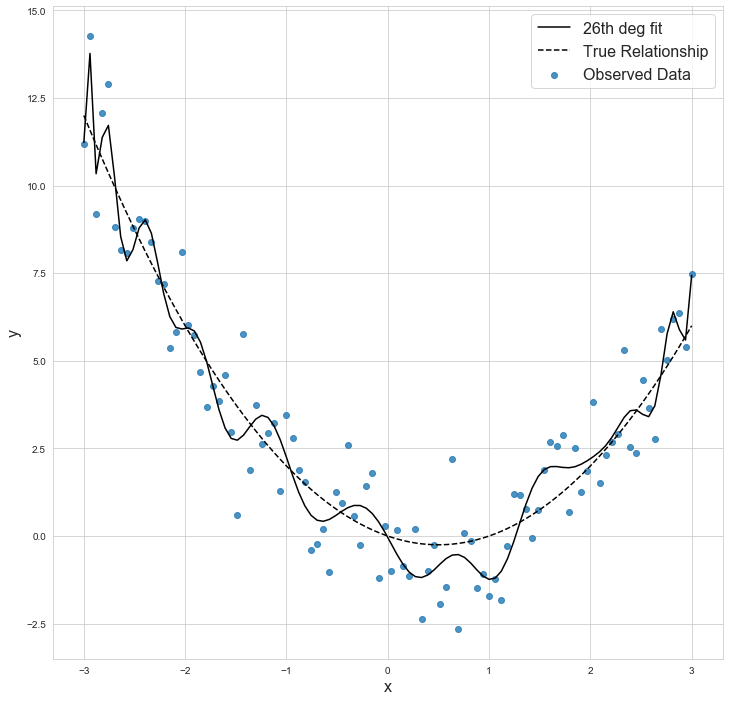

In [223]:

# plot to remind ourselves of the overfitting
plt.figure(figsize=(12,12))

plt.scatter(x, y, alpha = .8, label="Observed Data")

plt.plot(x,
         pipe.predict(x.reshape(-1,1)),
         'k', label= str(n) + "th deg fit")

plt.plot(x,x*(x-1),'k--',label = "True Relationship")

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.legend(fontsize=16)

plt.show()